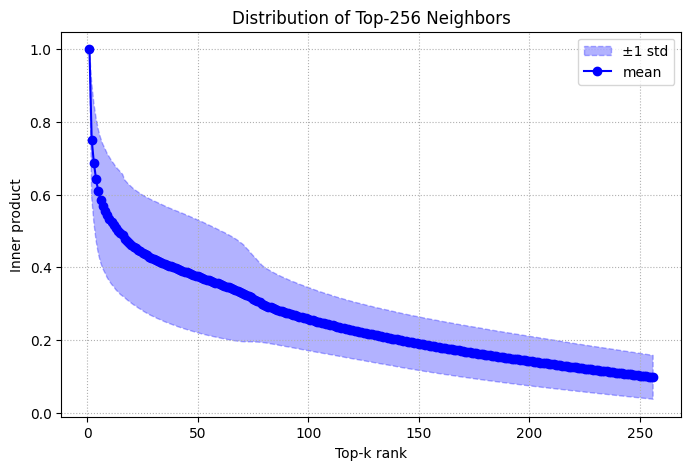

512


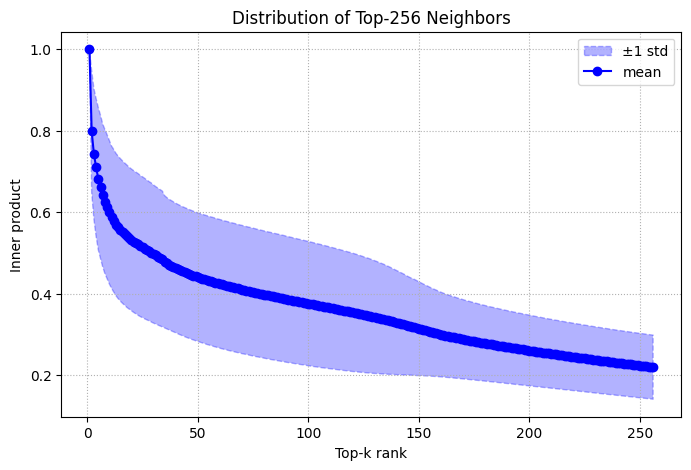

1024


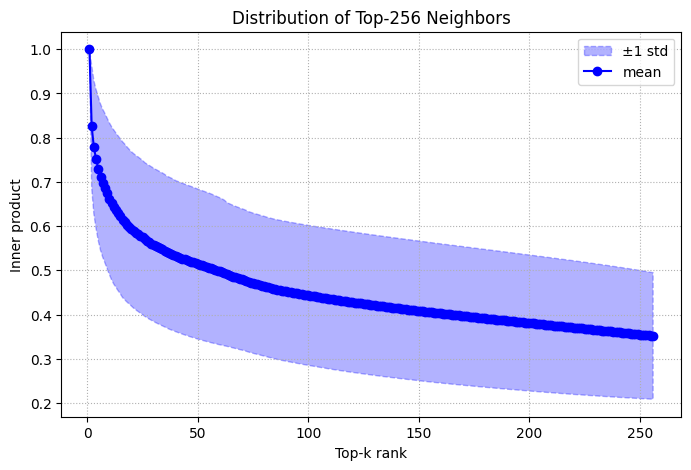

2048


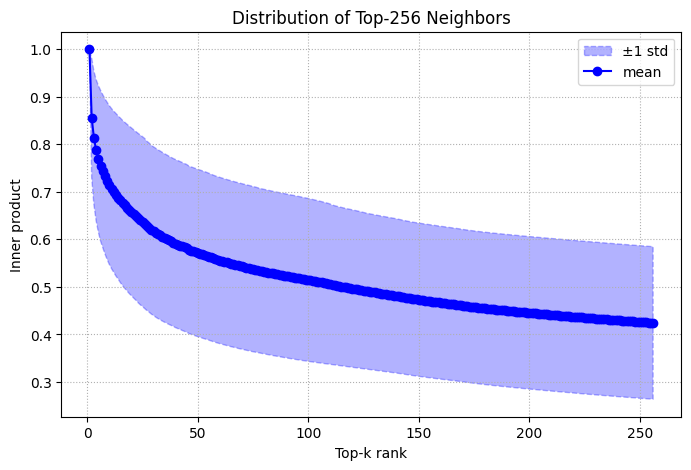

4096


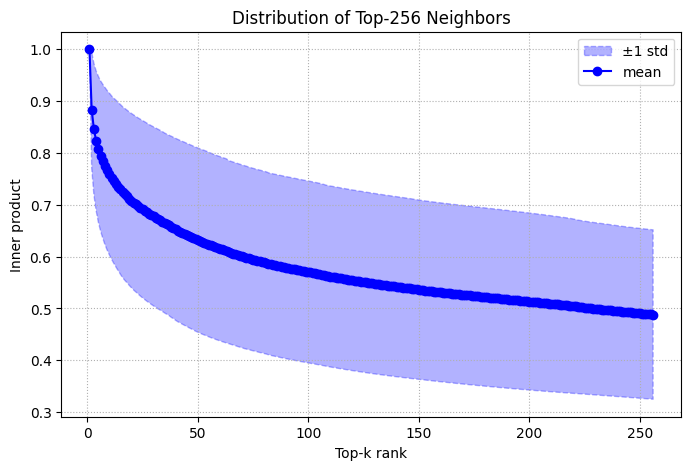

8192


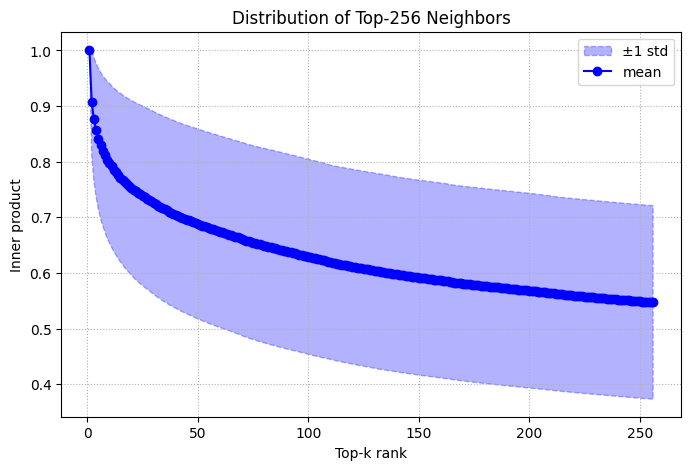

16384


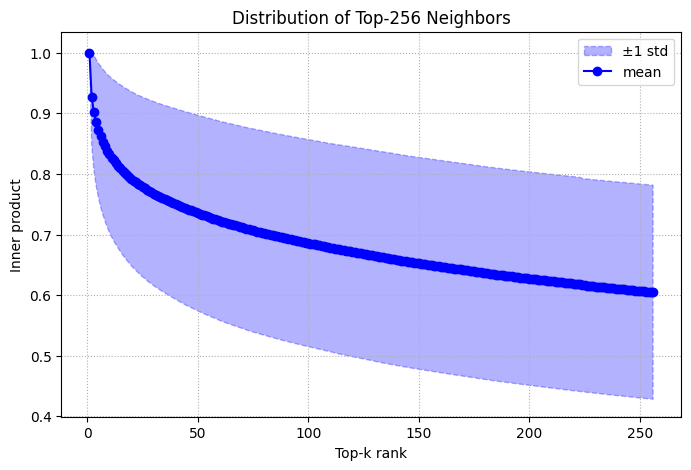

32768


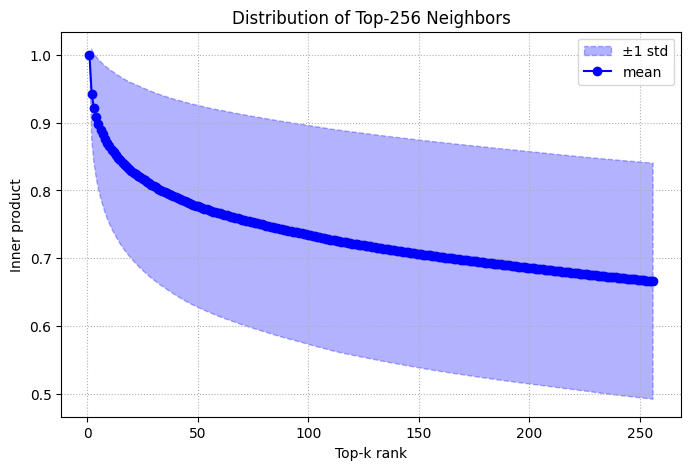

65536


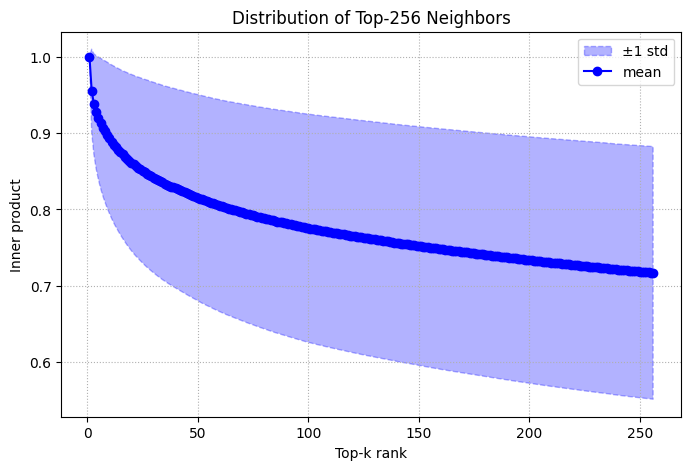

131072


In [4]:
# project.py
import torch
from safetensors.torch import load_file, save_file
import matplotlib.pyplot as plt
import numpy as np


def topk_neighbors(embeddings: torch.Tensor, k: int = 256, block_size: int = 4096):
    """
    embeddings: (N, d) 已归一化
    k: 取最近的前 k 个（包含自身）
    block_size: 分块大小
    返回: (N, k) 内积值, (N, k) 索引
    """
    device = torch.device("cuda:0")
    embeddings = embeddings.to(device, non_blocking=True)
    N, d = embeddings.shape
    result_ids, result_vals = [], []

    for start in range(0, N, block_size):
        end = min(start + block_size, N)
        block = embeddings[start:end]  # (B, d)
        sim = block @ embeddings.T     # (B, N)
        vals, idx = torch.topk(sim, k, dim=1, largest=True, sorted=True)
        result_vals.append(vals)
        result_ids.append(idx)

    return torch.cat(result_vals, dim=0), torch.cat(result_ids, dim=0)


def plot_topk_distribution(topk_vals: torch.Tensor, k: int = 64):
    """
    topk_vals: (N, K) 内积值
    k: 可视化前 k 个
    绘制均值点和方差区域
    """
    vals_cpu = topk_vals[:, :k].detach().cpu().numpy()  # (N, k)
    mean_vals = vals_cpu.mean(axis=0)
    std_vals  = vals_cpu.std(axis=0)

    x = np.arange(1, k+1)

    plt.figure(figsize=(8, 5))
    # 方差带 (均值 ± std)
    plt.fill_between(x, mean_vals-std_vals, mean_vals+std_vals,
                     alpha=0.3, color='blue', linestyle='--', label='±1 std')
    # 均值点
    plt.plot(x, mean_vals, 'o-', color='blue', label='mean')
    plt.xlabel("Top-k rank")
    plt.ylabel("Inner product")
    plt.title(f"Distribution of Top-{k} Neighbors")
    plt.legend()
    plt.grid(True, linestyle=":")
    plt.show()


if __name__ == "__main__":
    for size in [512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072]:
    # 1. 读取数据
        path = f"gpt65_normed_b128_iters_3999_l{size}_train_cache.pth"
        data = load_file(path)
        emb = data['emb']   # (N, d)，已归一化

        # 2. 计算 top-k
        vals, ids = topk_neighbors(emb, k=256)

        # 3. 绘图
        plot_topk_distribution(vals, k=256)
        
        filted_data = {
            "emb": data['emb'],
            "y"  : data['y'],
            "rk" : ids
        }
        
        save_file(filted_data, f"gpt65_normed_b128_iters_3999_l{size}_train_cache.pth")

        print(size)


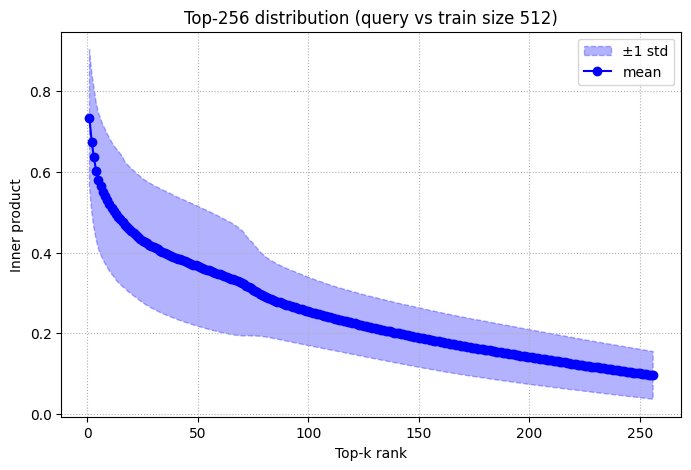

done size=512


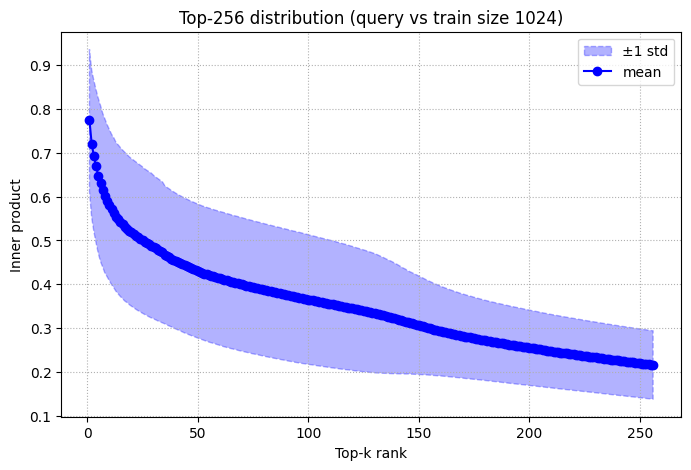

done size=1024


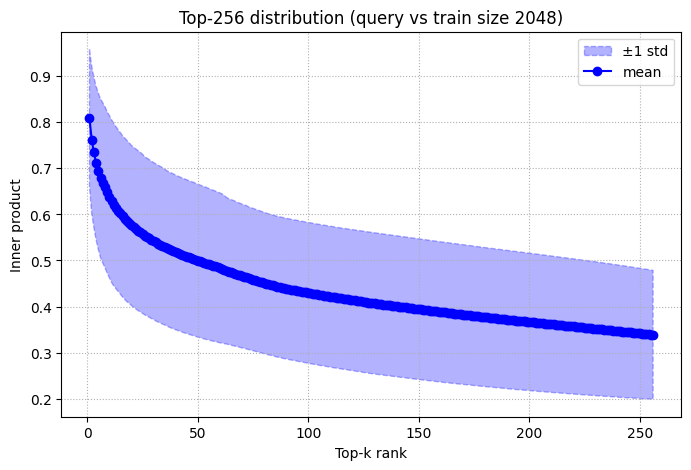

done size=2048


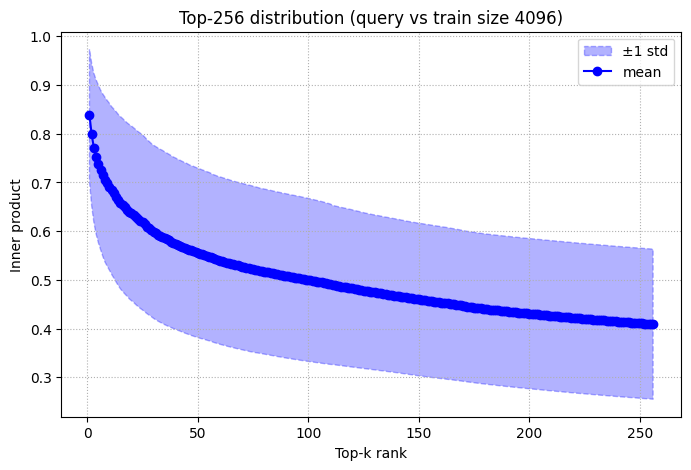

done size=4096


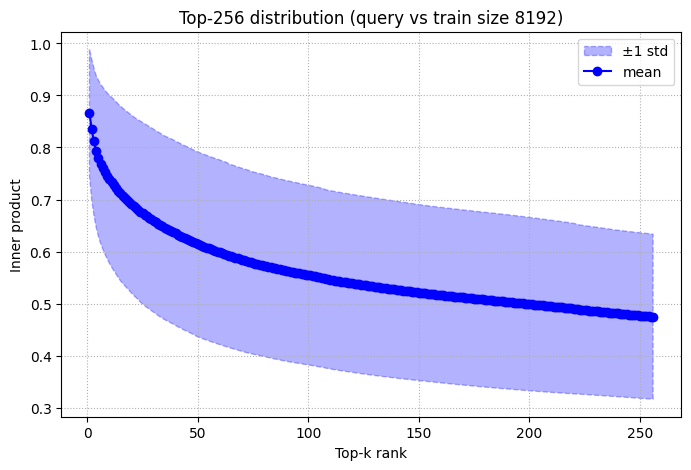

done size=8192


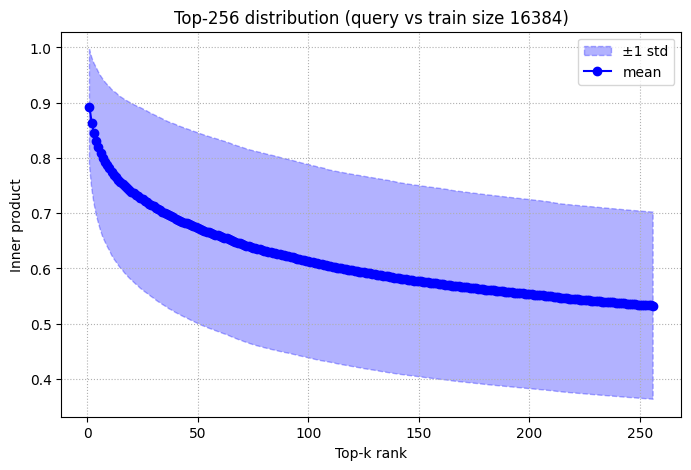

done size=16384


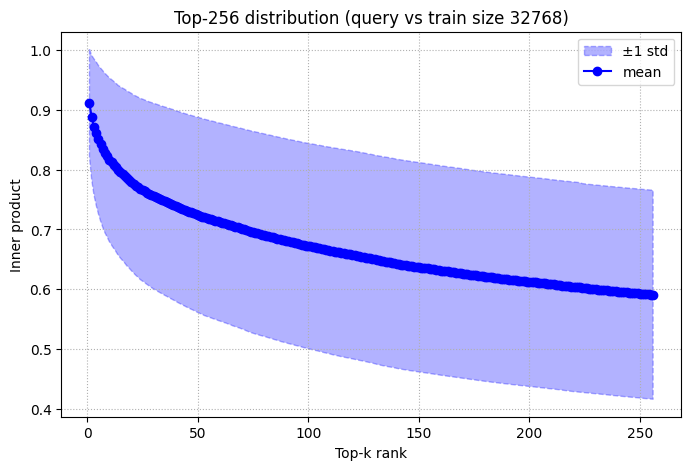

done size=32768


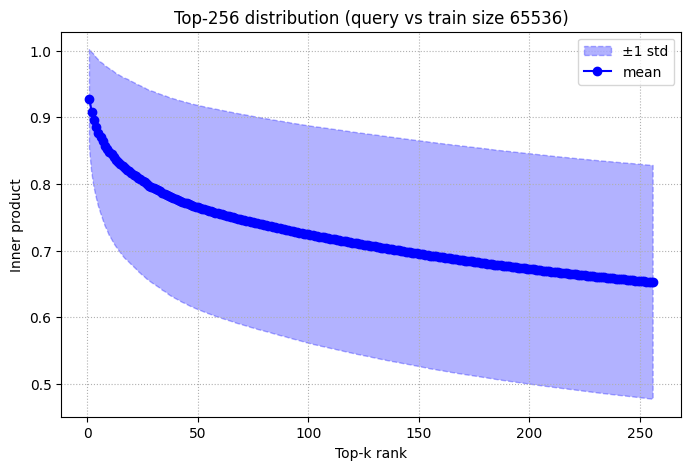

done size=65536


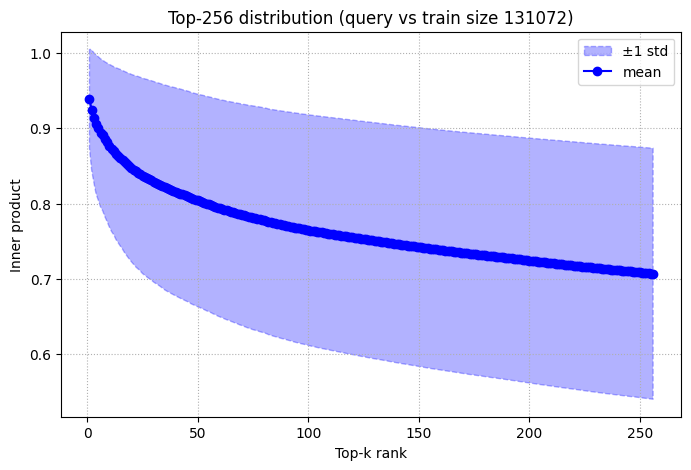

done size=131072


In [1]:
# project_cross.py
import torch
from safetensors.torch import load_file, save_file
import matplotlib.pyplot as plt
import numpy as np


def topk_cross_neighbors(query: torch.Tensor, base: torch.Tensor, k: int = 256, block_size: int = 4096):
    """
    query: (Nq, d) 查询向量，已归一化
    base : (Nb, d) 检索库向量，已归一化
    k: top-k 数
    block_size: 分块大小
    返回: (Nq, k) 内积值, (Nq, k) 索引 (索引在 base 内部)
    """
    device = torch.device("cuda:0")
    query = query.to(device, non_blocking=True)
    base  = base.to(device, non_blocking=True)

    Nq, d = query.shape
    result_ids, result_vals = [], []

    for start in range(0, Nq, block_size):
        end = min(start + block_size, Nq)
        block = query[start:end]       # (B, d)
        sim = block @ base.T           # (B, Nb)
        vals, idx = torch.topk(sim, k, dim=1, largest=True, sorted=True)
        result_vals.append(vals)
        result_ids.append(idx)

    return torch.cat(result_vals, dim=0), torch.cat(result_ids, dim=0)


def plot_topk_distribution(topk_vals: torch.Tensor, k: int = 64, title: str = ""):
    vals_cpu = topk_vals[:, :k].detach().cpu().numpy()  # (N, k)
    mean_vals = vals_cpu.mean(axis=0)
    std_vals  = vals_cpu.std(axis=0)

    x = np.arange(1, k+1)

    plt.figure(figsize=(8, 5))
    plt.fill_between(x, mean_vals-std_vals, mean_vals+std_vals,
                     alpha=0.3, color='blue', linestyle='--', label='±1 std')
    plt.plot(x, mean_vals, 'o-', color='blue', label='mean')
    plt.xlabel("Top-k rank")
    plt.ylabel("Inner product")
    plt.title(title if title else f"Distribution of Top-{k} Neighbors")
    plt.legend()
    plt.grid(True, linestyle=":")
    plt.show()


if __name__ == "__main__":
    # 1. 读取另一个文件 (比如 valid/test)
    other_path = "gpt65_normed_b128_iters_3999_l512_val_cache.pth"
    other_data = load_file(other_path)
    query_emb = other_data['emb']
    query_y   = other_data['y']

    # 2. 遍历 train 文件
    for size in [512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072]:
        train_path = f"gpt65_normed_b128_iters_3999_l{size}_train_cache.pth"
        train_data = load_file(train_path)
        base_emb = train_data['emb']

        # 3. 计算 cross top-k
        vals, ids = topk_cross_neighbors(query_emb, base_emb, k=256)

        # 4. 绘图
        plot_topk_distribution(vals, k=256,
                               title=f"Top-256 distribution (query vs train size {size})")

        # 5. 保存结果
        filtered_data = {
            "emb": query_emb,
            "y":   query_y,
            "rk":  ids
        }
        save_file(filtered_data,
                  f"gpt65_normed_b128_iters_3999_l512_valid_cache_queried_l{size}.pth")

        print(f"done size={size}")
